In [9]:
%cd /content/drive/MyDrive/WorkSpace/AI_Research/EmotionTorch/code/

/content/drive/MyDrive/WorkSpace/AI_Research/EmotionTorch/code


In [10]:
!pip install pytorchcv -q
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from utils.datasets.fer2013_ds import FERDataset
# from models.vgg16_cbam import  VGG19_CBAM
from models.resnet_cbam import ResidualNet , cbam_resnet50
from models.vggnet import vgg16_bn, vgg19, vgg19_bn, vgg16
from models.resnet import resnet50, resnet34
from models.vggnet_cbam import vgg16_cbam, vgg19_cbam
from models.vggnet_cbam_pre import *
from models.ResNetVDSR import resnetvdsr_dropout1
from models.resmasking import *
from models.DeepResblock import *
from torch.utils.data import DataLoader

from utils.visualize.show_img import show_image_dataset
from trainer.fer2013_trainer import FER2013_Trainer
import json

import matplotlib.pyplot as plt 
import cv2
import numpy as np

In [27]:

import torch
from torch.autograd import Variable
from torch.autograd import Function
from torchvision import models
from torchvision import utils
import cv2
import numpy as np
import argparse

# from .resnet import BasicBlock, Bottleneck, ResNet, resnet18

try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

model_urls = {
    "resnet18": "https://download.pytorch.org/models/resnet18-5c106cde.pth",
    "resnet34": "https://download.pytorch.org/models/resnet34-333f7ec4.pth",
    "resnet50": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
}

EMOTION_DICT = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral",
}
# # from .new_DRAB import *
class FeatureExtractor:
  def __init__(self, model):
    self.model = model
    self.gradient = []

  def save_gradient(self, grad):
    self.gradient.append(grad)

  def __call__(self, x):
      outputs = []
      self.gradients = []

      x = self.model.conv1(x)  # 112
      x = self.model.bn1(x)
      x = self.model.relu(x)
      x = self.model.maxpool(x)  # 56

      x = self.model.layer1(x)  # 56
      x = self.model.layer2(x)  # 28
      x = self.model.layer3(x)  # 14
      x = self.model.layer4(x)  # 7

      x.register_hook(self.save_gradient)
      outputs += [x]

      return outputs, x
  
class ModelOutputs:
  def __init__(self, model, target_layers):
    self.model = model
    self.features_extractor = FeatureExtractor(self.model)

  def get_gradients(self):
    return self.features_extractor.gradient

  def __call__(self, x):
    target_activations, output = self.features_extractor(x)
    output = self.model.avgpool(output)
    output = torch.flatten(output, 1)
    output = self.model.fc(output)

    return target_activations, output

def show_cam_on_image(img, mask, image_name = ""):
  heatmap = cv2.applyColorMap(np.uint8(255*mask), cv2.COLORMAP_JET)
  heatmap = np.float32(heatmap) / 255
  cam = heatmap + np.float32(img)
  cam = cam / np.max(cam)
class GradCam:
    def __init__(self, model, target_layer_names, use_cuda):
        self.model = model
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()

        self.extractor = ModelOutputs(self.model, target_layer_names)

    def forward(self, input):
        return self.model(input)

    def __call__(self, input, index=None):
        if self.cuda:
            features, output = self.extractor(input.cuda())
        else:
            features, output = self.extractor(input)

        if index == None:
            index = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][index] = 1
        one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
        if self.cuda:
            one_hot = torch.sum(one_hot.cuda() * output)
        else:
            one_hot = torch.sum(one_hot * output)

        # self.model.features.zero_grad()
        # self.model.classifier.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis=(2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

Training_26728.jpg


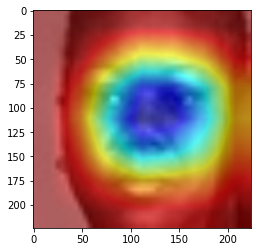

In [32]:
# from models.grad_cam_resmaking import resmasking_dropout1

model = resmasking_dropout1(num_classes = 7)
# state = torch.load('./saved/checkpoints/resmasking_dropout1_rot30_2019Nov17_14.33')
state = torch.load(
    "/content/drive/MyDrive/WorkSpace/AI_Research/EmotionTorch/resmasking_dropout1_rot30_2019Nov17_14.33", map_location=torch.device('cpu')
)
model.load_state_dict(state["net"])

# Can work with any model, but it assumes that the model has a
# feature method, and a classifier method,
# as in the VGG models in torchvision.
"""
grad_cam = GradCam(
    model=models.vgg19(pretrained=True),
    target_layer_names = ["35"],
    use_cuda=args.use_cuda
)
"""
grad_cam = GradCam(model=model, target_layer_names=["35"], use_cuda=False)

from torchvision.transforms import transforms

transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])

import os
import glob
from natsort import natsorted

# for image_path in natsorted(glob.glob('/home/z/research/archive_for_tee/face_CK+/only_face/*.png')):
# for image_path in natsorted(glob.glob('./affectnet_face/*.png')):
# for image_path in natsorted(glob.glob('./vemo_face/*.png')):
# for image_path in natsorted(
#     glob.glob("/**/home/z/research/bkemo/debug/*.png", recursive=True)
# ):
image_name = os.path.basename("/content/Training_26728.jpg")
print(image_name)
image = cv2.imread("/content/Training_26728.jpg")
# image = cv2.imread('sample.png')
image = cv2.resize(image, (224, 224))
tensor = transform(image)
tensor = torch.unsqueeze(tensor, 0)

# img = np.float32(cv2.resize(img, (224, 224))) / 255
# input = preprocess_image(img)

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested index.
target_index = None

mask = grad_cam(tensor, target_index)

image = np.float32(cv2.resize(image, (224, 224))) / 255
# show_cam_on_image(image, mask, image_name='')

heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
cam = heatmap + np.float32(image)
cam = cam / np.max(cam)
# cv2.imwrite('./resmasking_gradcam_affect/{}'.format(image_name), np.uint8(255 * cam))
cv2.imwrite("content/{}".format(image_name), np.uint8(255 * cam))
cam = np.uint8(255 * cam)
import matplotlib.pyplot as plt
plt.imshow(cam)

In [ ]:
model = ResNet34()

In [ ]:
model.gradient

In [ ]:
def get_gradcam(model, image, label, size):

  label.backward()
  gradients = model.get_activation()
  pooled_gradients = torch.mean(gradient, )